# Homework 03 - Classification

In [4]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from IPython.display import display

In [5]:
%matplotlib inline

## Preparing the Dataset

In [6]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
response = requests.get(url)
outer_zip = zipfile.ZipFile(io.BytesIO(response.content))
print(outer_zip.namelist()) 

['bank.zip', 'bank-additional.zip']


In [7]:
with outer_zip.open('bank.zip') as inner_zip_file:
    inner_zip = zipfile.ZipFile(inner_zip_file)
    
    with inner_zip.open('bank-full.csv') as csvfile:
        df = pd.read_csv(csvfile, sep=';')

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
# transform columns to snake case
df.columns = df.columns.str.lower().str.replace(' ', '_')

# transform string data to snake case
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [10]:
base = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

df = df[base]

In [11]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Question 1

What is the most frequent observation (mode) for the column education?

In [12]:
df.education.value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [13]:
print(f"The most frequent value (mode) in the 'education' column is {df.education.mode()[0]}.")

The most frequent value (mode) in the 'education' column is secondary.


## Question 2

Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?
1) age and balance
2) day and campaign
3) day and pdays
4) pdays and previous

Target encoding:

- Now we want to encode the y variable.
- Let's replace the values yes/no with 1/0.

Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value y is not in your dataframe.

In [14]:
numerical = [
    'age',
    'balance',
    'day',
    'duration',
    'campaign',
    'pdays',
    'previous'
]

df_numerical = df[numerical]

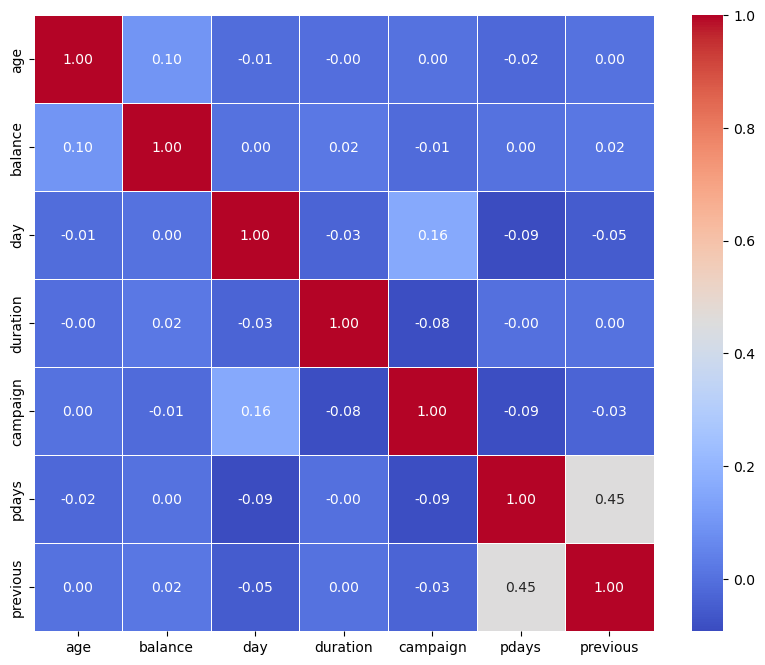

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [16]:
print(f"The two features that have the biggest correlation are 'pdays' and 'previous'.")

The two features that have the biggest correlation are 'pdays' and 'previous'.


### Target Encoding

In [17]:
df.y.value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [18]:
df.y = (df.y == 'yes').astype(int)

In [19]:
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [20]:
df.y.value_counts(normalize=True)

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64

In [21]:
df.y.mean()

0.11698480458295547

In [22]:
df_numerical.corrwith(df.y).abs().sort_values(ascending=False)

duration    0.394521
pdays       0.103621
previous    0.093236
campaign    0.073172
balance     0.052838
day         0.028348
age         0.025155
dtype: float64

### Split the Data

In [23]:
X = df.drop(columns=['y'])
y = df['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

(27126, 9042, 9043)

## Question 3

- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?
1) contact
2) education
3) housing
4) poutcome


In [24]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [25]:
def mutual_info_y_score(series):
    return mutual_info_score(series, y_train)

In [26]:
mi = X_train[categorical].apply(mutual_info_y_score)
mi.sort_values(ascending=False).round(2)

poutcome     0.03
month        0.02
contact      0.01
housing      0.01
job          0.01
education    0.00
marital      0.00
dtype: float64

In [27]:
print(f"The variable with the highest mutual information is 'poutcome'.")

The variable with the highest mutual information is 'poutcome'.


## Question 4

Now let's train a logistic regression: 

- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

- Calculate the accuracy on the validation dataset and round it to 2 decimal digits. What accuracy did you get?
1) 0.6
2) 0.7
3) 0.8
4) 0.9


In [28]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [29]:
categorical, categorical_features

(['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'],
 ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'])

In [30]:
numerical, numerical_features

(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set is: {validation_accuracy:.2f}')

 The accuracy on the validation set is: 0.90


## Question 5

- Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?
1. age
2. balance
3. marital
4. previous

Note: The difference doesn't have to be positive.


### All features

In [32]:
Q5 = ['age', 'balance', 'marital', 'previous', 'y']

dfq5 = df[Q5].copy()
X = dfq5.drop(columns=['y'])
y = dfq5['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_all = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features is: {validation_accuracy_all:.2f}')

 The accuracy on the validation set of all features is: 0.88


### All Features but `age`

In [33]:
Q5 = ['balance', 'marital', 'previous', 'y']

dfq5 = df[Q5]
X = dfq5.drop(columns=['y'])
y = dfq5['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_age = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but age is: {validation_accuracy_age:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_age}')

 The accuracy on the validation set of all features but age is: 0.88
 The difference between accuracies is: 0.0


### All Features but `balance`

In [34]:
Q5 = ['age', 'marital', 'previous', 'y']

dfq5 = df[Q5]
X = dfq5.drop(columns=['y'])
y = dfq5['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_balance = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but balance is: {validation_accuracy_balance:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_balance}')

 The accuracy on the validation set of all features but balance is: 0.88
 The difference between accuracies is: 0.00011059500110588427


### All Features but `marital`

In [35]:
Q5 = ['age', 'balance', 'previous', 'y']

dfq5 = df[Q5]
X = dfq5.drop(columns=['y'])
y = dfq5['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_marital = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but marital is: {validation_accuracy_marital:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_marital}')

 The accuracy on the validation set of all features but marital is: 0.88
 The difference between accuracies is: -0.0001105950011059953


### All Features but `previous`

In [36]:
Q5 = ['age', 'balance', 'marital', 'y']

dfq5 = df[Q5]
X = dfq5.drop(columns=['y'])
y = dfq5['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

validation_accuracy_previous = pipeline.score(X_val, y_val)
print(f' The accuracy on the validation set of all features but previous is: {validation_accuracy_previous:.2f}')
print(f' The difference between accuracies is: {validation_accuracy_all - validation_accuracy_previous}')

 The accuracy on the validation set of all features but previous is: 0.88
 The difference between accuracies is: -0.0014377350143773837


In [37]:
df_accuracies = pd.DataFrame(
    [validation_accuracy_all, validation_accuracy_age, validation_accuracy_balance, validation_accuracy_marital, validation_accuracy_previous], 
    index=['all', 'age', 'balance', 'marital', 'previous'],
    columns=['validation_accuracy']
)

df_differences = pd.DataFrame(
    [validation_accuracy_all - validation_accuracy_all, 
     validation_accuracy_all - validation_accuracy_age, 
     validation_accuracy_all - validation_accuracy_balance, 
     validation_accuracy_all - validation_accuracy_marital, 
     validation_accuracy_all - validation_accuracy_previous], 
    index=['all', 'age', 'balance', 'marital', 'previous'],
    columns=['difference_from_all']
)

df_result = pd.concat([df_accuracies, df_differences], axis=1)
df_result.sort_values(by='validation_accuracy', ascending=False)


,validation_accuracy,difference_from_all
previous,0.883986,-0.001438
marital,0.882659,-0.000111
all,0.882548,0.000000
age,0.882548,0.000000
balance,0.882438,0.000111


## Question 6

- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?

1. 0.01
2. 0.1
3. 1
4. 10
5. 100


In [39]:
Q6 = ['age', 'balance', 'marital', 'previous', 'y']

Cs = [0.01, 0.1, 1, 10, 100]
results = []

dfq6 = df[Q6].copy()
X = dfq6.drop(columns=['y'])
y = dfq6['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

for C in Cs:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42))
    ])
    
    pipeline.fit(X_train, y_train)
    validation_accuracy = pipeline.score(X_val, y_val)
    results.append({'C': C, 'Validation Accuracy': validation_accuracy})

results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by='Validation Accuracy', ascending=False)

sorted_results.round(3)

,C,Validation Accuracy
0,0.01,0.883
1,0.10,0.883
2,1.00,0.883
3,10.00,0.883
4,100.00,0.883
